In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Imports
"""

import os
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import lightning as L
import lightning.pytorch as pl

torch.set_float32_matmul_precision('medium')

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")

# Check Data Module

In [6]:
from train import DocDenoiserDataModule
dm = DocDenoiserDataModule()

In [7]:
dm.setup(stage='fit')

17:50:38 | INFO     | Total Dataset       : 144 samples
17:50:38 | INFO     | Train Dataset       : 115 samples
17:50:38 | INFO     | Validation Dataset  : 29 samples


In [8]:
dl = dm.train_dataloader()
batch = next(iter(dl))

In [9]:
X_noisy, X = batch
X_noisy.shape, X.shape

(torch.Size([8, 1, 420, 540]), torch.Size([8, 1, 420, 540]))

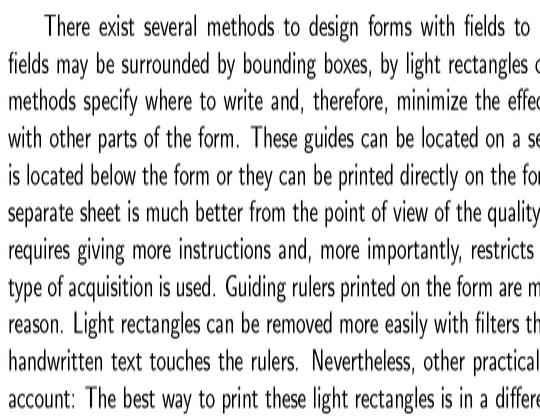

In [10]:
from utils.visualize import tensor_to_pil_image
tensor_to_pil_image(X[0])

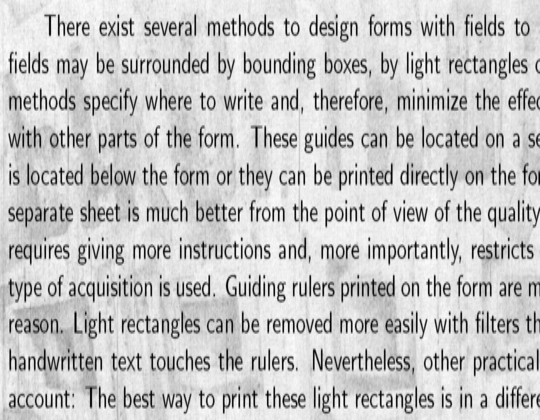

In [12]:
tensor_to_pil_image(X_noisy[0])

# Check Model

In [58]:
from train import DocDenoiserAutoencoder
model = DocDenoiserAutoencoder()

In [59]:
out = model(X_noisy)
out.shape

10:21:21 | DEBUG    | Input shape : torch.Size([8, 1, 420, 540])
10:21:24 | DEBUG    | Encoder Output shape : torch.Size([8, 128, 210, 270])
10:21:27 | DEBUG    | Decoder Output shape : torch.Size([8, 1, 420, 540])


torch.Size([8, 1, 420, 540])

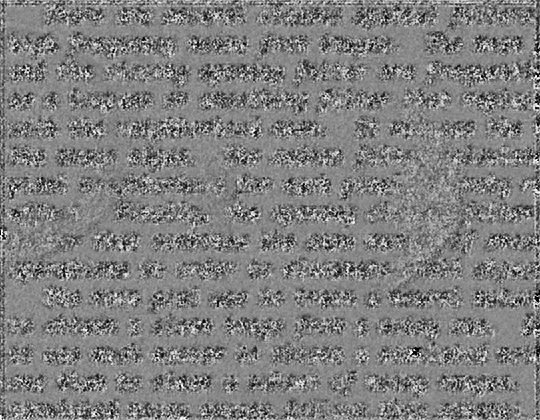

In [63]:
tensor_to_pil_image(out[0])

# Check Samples

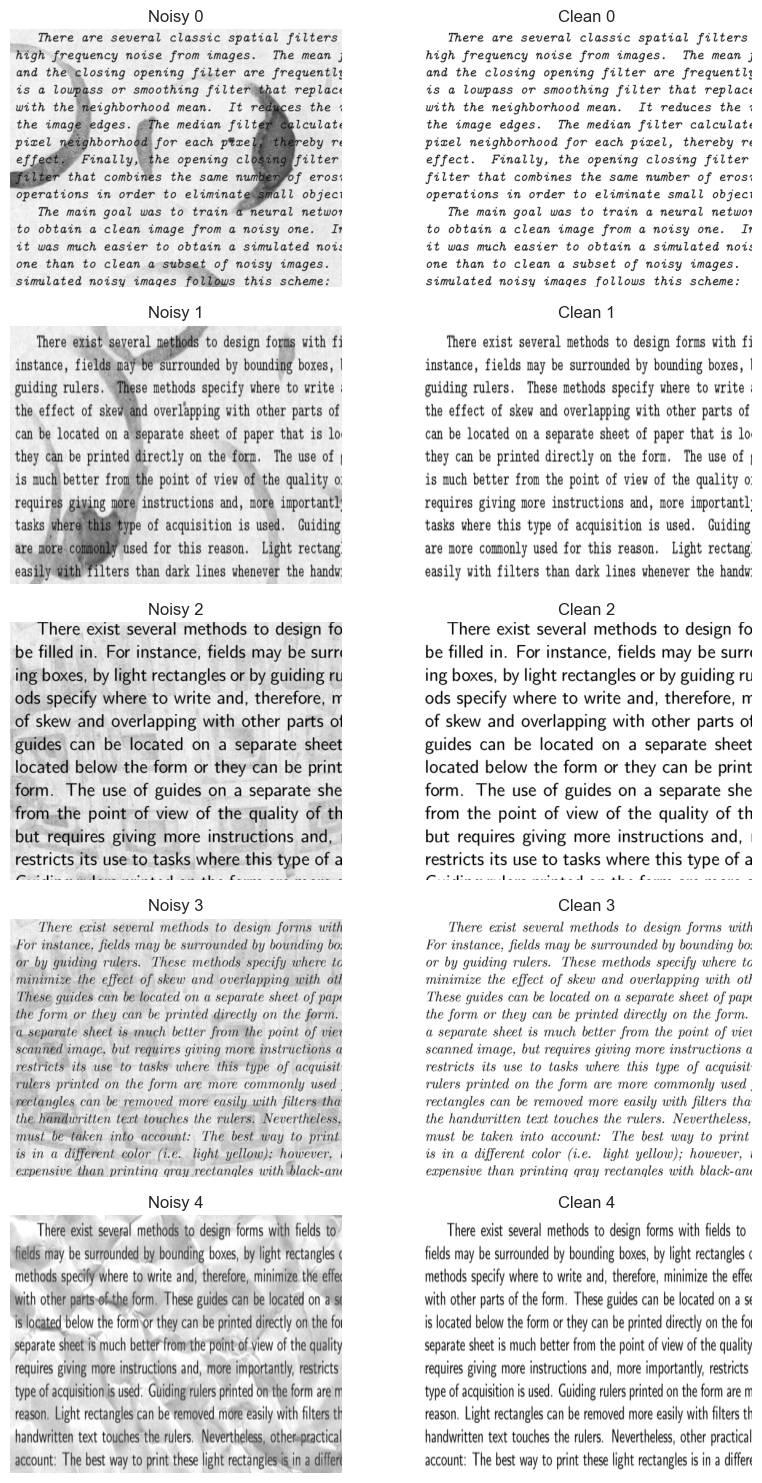

In [60]:
from utils.visualize import visualize_images_from_batch
visualize_images_from_batch(batch, col_titles=('Noisy', 'Clean'))

# Check Model Shapes

In [1]:
class DocDenoiserAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.relu5 = nn.ReLU()
        self.batchnorm5 = nn.BatchNorm2d(256)

        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.relu6 = nn.ReLU()
        self.batchnorm6 = nn.BatchNorm2d(128)

        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.relu7 = nn.ReLU()
        self.batchnorm7 = nn.BatchNorm2d(64)

        self.deconv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        logger.debug(f'Input shape: {x.shape}')
        
        x = self.conv1(x)
        logger.debug(f'After conv1: {x.shape}')
        x = self.relu1(x)
        x = self.batchnorm1(x)
        logger.debug(f'After batchnorm1: {x.shape}')
        x = self.pool1(x)
        logger.debug(f'After pool1: {x.shape}')

        x = self.conv2(x)
        logger.debug(f'After conv2: {x.shape}')
        x = self.relu2(x)
        x = self.batchnorm2(x)
        logger.debug(f'After batchnorm2: {x.shape}')
        x = self.pool2(x)
        logger.debug(f'After pool2: {x.shape}')

        x = self.conv3(x)
        logger.debug(f'After conv3: {x.shape}')
        x = self.relu3(x)
        x = self.batchnorm3(x)
        logger.debug(f'After batchnorm3: {x.shape}')
        x = self.pool3(x)
        logger.debug(f'After pool3: {x.shape}')

        x = self.conv4(x)
        logger.debug(f'After conv4: {x.shape}')
        x = self.relu4(x)
        x = self.batchnorm4(x)
        logger.debug(f'After batchnorm4: {x.shape}')
        x = self.pool4(x)
        logger.debug(f'After pool4: {x.shape}')

        x = self.deconv1(x)
        logger.debug(f'After deconv1: {x.shape}')
        x = self.relu5(x)
        x = self.batchnorm5(x)
        logger.debug(f'After batchnorm5: {x.shape}')

        x = self.deconv2(x)
        logger.debug(f'After deconv2: {x.shape}')
        x = self.relu6(x)
        x = self.batchnorm6(x)
        logger.debug(f'After batchnorm6: {x.shape}')

        x = self.deconv3(x)
        logger.debug(f'After deconv3: {x.shape}')
        x = self.relu7(x)
        x = self.batchnorm7(x)
        logger.debug(f'After batchnorm7: {x.shape}')

        x = self.deconv4(x)
        logger.debug(f'After deconv4: {x.shape}')
        x = self.sigmoid(x)
        logger.debug(f'After sigmoid: {x.shape}')
        
        return x


NameError: name 'nn' is not defined

In [8]:
import math

def pooling_params(input_size, output_size):
    """
    Given an input size (height, width) and output size (height, width), this function returns
    the kernel size, stride, and padding required for a pooling operation.
    
    Args:
    input_size: tuple, (input_height, input_width)
    output_size: tuple, (output_height, output_width)
    
    Returns:
    kernel_size, stride, padding: int, int, int
    """
    input_height, input_width = input_size
    output_height, output_width = output_size

    def calculate_params(in_size, out_size):
        """
        Calculates the kernel size, stride, and padding for a given input and output size.
        """
        # Assume no padding (P = 0) and stride equal to the scaling ratio
        stride = math.ceil(in_size / out_size)
        kernel_size = in_size - (out_size - 1) * stride
        
        # Adjust the kernel size if necessary to match exact output
        if (in_size - kernel_size) % stride != 0:
            padding = (stride - (in_size - kernel_size) % stride) // 2
        else:
            padding = 0
        
        return kernel_size, stride, padding

    # Calculate for height and width
    kernel_h, stride_h, padding_h = calculate_params(input_height, output_height)
    kernel_w, stride_w, padding_w = calculate_params(input_width, output_width)
    
    return (kernel_h, kernel_w), (stride_h, stride_w), (padding_h, padding_w)

In [ ]:
# kernel_size, stride, padding = pooling_params(input_size, output_size)
# print(f"Kernel Size: {kernel_size}")
# print(f"Stride: {stride}")
# print(f"Padding: {padding}")

In [9]:
import math

def convtrans2d_params(input_size, output_size, output_padding=0):
    """
    Given an input size (height, width) and desired output size (height, width),
    this function returns the kernel size, stride, and padding required for a ConvTranspose2d operation.
    
    Args:
    input_size: tuple, (input_height, input_width)
    output_size: tuple, (output_height, output_width)
    output_padding: int, default 0, additional output padding
    
    Returns:
    kernel_size, stride, padding: int, int, int
    """
    input_height, input_width = input_size
    output_height, output_width = output_size

    def calculate_params(in_size, out_size):
        """
        Calculates the kernel size, stride, and padding for a given input and output size
        for ConvTranspose2d operation.
        """
        # Assume no padding and the stride is the scaling ratio
        stride = math.ceil((out_size - 1) / (in_size - 1))
        
        # Now calculate the kernel size using the transpose formula
        kernel_size = out_size - (in_size - 1) * stride + 2 * 0 - output_padding
        
        # Set padding to zero (can adjust this part if padding is required)
        padding = 0
        
        return kernel_size, stride, padding

    # Calculate for height and width
    kernel_h, stride_h, padding_h = calculate_params(input_height, output_height)
    kernel_w, stride_w, padding_w = calculate_params(input_width, output_width)
    
    return (kernel_h, kernel_w), (stride_h, stride_w), (padding_h, padding_w)

# Example Usage:
input_size = (206, 270)
output_size = (420, 540)

kernel_size, stride, padding = convtrans2d_params(input_size, output_size)
print(f"Kernel Size: {kernel_size}")
print(f"Stride: {stride}")
print(f"Padding: {padding}")


Kernel Size: (-195, -267)
Stride: (3, 3)
Padding: (0, 0)
